<a href="https://colab.research.google.com/github/h5ng/uos_bigdata/blob/main/%EA%B3%BC%EC%A0%9C_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.manythings.org/anki/kor-eng.zip && unzip /content/kor-eng.zip
#!wget http://www.manythings.org/anki/fra-eng.zip && unzip /content/fra-eng.zip

--2021-05-26 08:02:21--  http://www.manythings.org/anki/kor-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143703 (140K) [application/zip]
Saving to: ‘kor-eng.zip.7’

kor-eng.zip.7       100%[===================>] 140.33K   467KB/s    in 0.3s    

2021-05-26 08:02:22 (467 KB/s) - ‘kor-eng.zip.7’ saved [143703/143703]

Archive:  /content/kor-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: _about.txt              
  inflating: kor.txt                 


In [2]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np
import pandas as pd

from numpy.random import seed
seed(1)

#from tensorflow import set_random_seed
#set_random_seed(2)

In [3]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'kor.txt'

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Loop over lines
lines = open(data_path).read().split('\n')
#for line in lines[: len(lines) - 1]:
for line in lines[: 3600]:  
    symbols = """!@#$%^&*()_-+={[}]|\;:"‘·<>?/., """
    line = line.split('\t')
    input_text, target_text = line[0].replace(symbols, ''), line[1].replace(symbols, '')
    
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print('Number of samples:', len(input_texts))

Number of samples: 3600


In [5]:
input_characters = sorted(list(input_characters)) 
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) 
num_decoder_tokens = len(target_characters)


print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 74
Number of unique output tokens: 902


In [6]:
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

In [8]:
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # Get longest sequences length
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Max sequence length for inputs: 62
Max sequence length for outputs: 49


In [9]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [11]:
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name = 'encoder_inputs')

encoder = CuDNNLSTM(latent_dim, 
                    return_state=True, 
                    name = 'encoder')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens), 
                       name = 'decoder_inputs')

decoder_lstm = CuDNNLSTM(latent_dim, 
                         return_sequences=True, 
                         return_state=True, 
                         name = 'decoder_lstm')

decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/200
45/45 [==============================] - 16s 46ms/step - loss: 1.4981 - val_loss: 2.2211
Epoch 2/200
45/45 [==============================] - 1s 32ms/step - loss: 1.3472 - val_loss: 2.2222
Epoch 3/200
45/45 [==============================] - 1s 32ms/step - loss: 1.3140 - val_loss: 2.2052
Epoch 4/200
45/45 [==============================] - 1s 32ms/step - loss: 1.3175 - val_loss: 2.2061
Epoch 5/200
45/45 [==============================] - 1s 33ms/step - loss: 1.3081 - val_loss: 2.2036
Epoch 6/200
45/45 [==============================] - 1s 31ms/step - loss: 1.3064 - val_loss: 2.2034
Epoch 7/200
45/45 [==============================] - 1s 31ms/step - loss: 1.3063 - val_loss: 2.1995
Epoch 8/200
45/45 [==============================] - 1s 32ms/step - loss: 1.2884 - val_loss: 2.1955
Epoch 9/200
45/45 [==============================] - 1s 32ms/step - loss: 1.2966 - val_loss: 2.1960
Epoch 10/200
45/45 [==============================] - 1s 32ms/step - loss: 1.2966 - val_loss: 2.196

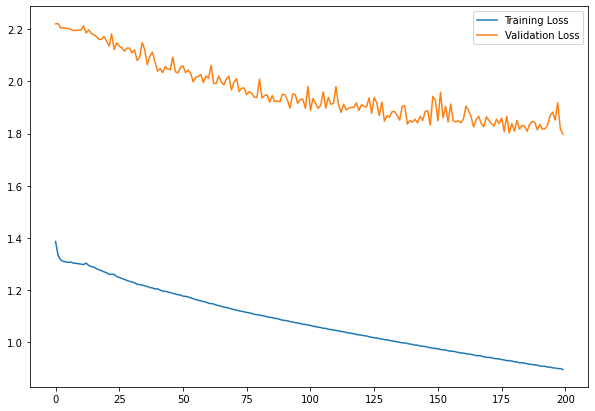

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

In [14]:
encoder_model = Model(encoder_inputs, encoder_states)

In [15]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [16]:
reverse_input_char_index = {i: char 
                            for char, i in input_token_index.items()}
reverse_target_char_index = {i: char 
                             for char, i in target_token_index.items()}

In [17]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [37]:
my_text = 'Tom knows'
placeholder = np.zeros((1,len(my_text)+10,num_encoder_tokens))

for i, char in enumerate(my_text):
    print(i,char, input_token_index[char])
    placeholder[0,i,input_token_index[char]] = 1

decode_sequence(placeholder)

0 T 41
1 o 60
2 m 58
3   0
4 k 56
5 n 59
6 o 60
7 w 68
8 s 64


'톰 이어 어.\n'

In [20]:
!pip install wordcloud

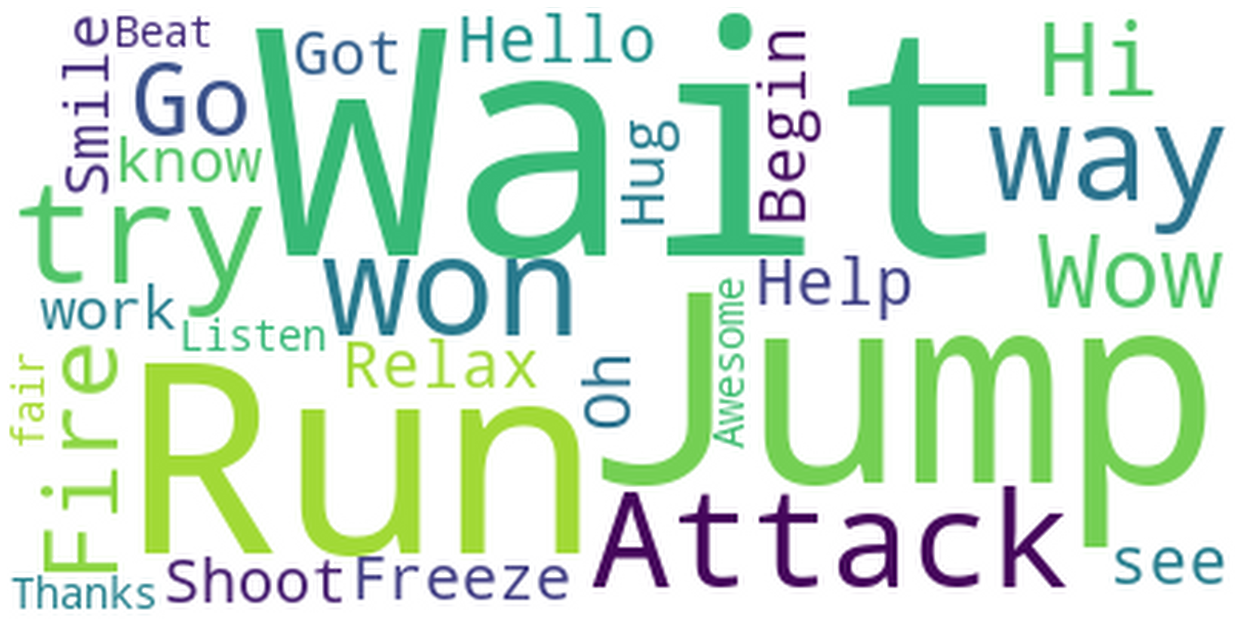

In [33]:
from wordcloud import WordCloud 

words = ''
for input in input_texts:
  for w in input.split(' '):
    words += w + ' '

wc = WordCloud(background_color='white').generate(words)
plt.figure(figsize=(22,22))
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.show() 